In [2]:
import os, random

import numpy as np
import torch

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# Lab: Détection de texte généré automatiquement

Nous allons travailler sur un jeu de données généré à partir du dataset de Myle Ott, "<a href="https://myleott.com/op-spam.html">Deceptive Opinion Spam Corpus v1.4</a>".

Le jeu de données a été modifié pour inclure des reviews d'hotel générées automatiquement avec le modèle GPT-3

Pour chaque review originale, nous avons créé une fausse review à partir d'un seed de 10 mots de la review originale et demandé au modèle de langage de compléter jusqu'à la taille de la review originale, en respectant la polarité de la review originale.

Un exemple:

*original negative*
```t_allegro_1.txt```
> This hotel must have originally been an ordinary downtown hotel in a not very nice neighborhood. The owners have painted it over and fixed up the lobby to make it an "upscale" overpriced boutique hotel. But it's still just an ordinary hotel with a paint job. Stay here if you want to experience staying in a flophouse, but with all the sleaze removed. Definitely stay at the chain's other location, the Burnham, for a much, much nicer hotel.

*generated negative*
```g_allegro_1.txt```
> This hotel must have originally been an ordinary downtown hotel but now it is hardly more than a shabby motel. The walls are dirty and the furniture is worn, with some broken pieces. My room smelled musty and the carpets had stains. The bed was uncomfortable and the linen was old and threadbare. The staff were not particularly helpful and I felt like I was an inconvenience to them.

Le bloc suivant nous permet de charger le dataset complet:

In [3]:
def find_txt_files(directory):
    txt_files = []

    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith('.txt') and 'deceptive' not in root: #we don't consider the fake reviews
                txt_files.append(os.path.join(root, file))

    return txt_files

d1 = 'generated_GPT3_negative'
d2 = 'generated_GPT3_positive'
gen_txt_files = find_txt_files(d1)
gen_txt_files = gen_txt_files + (find_txt_files(d2))

not_gen = find_txt_files('not_generated')

gen_texts = []
pol_labels = [] #this will keep track whether the review is positive or negative
for txt_file in gen_txt_files:
    if "positive" in txt_file:
        pol_label=1
    else:
        pol_label=-1
    pol_labels.append(pol_label)
    with open(txt_file, 'r') as file:
        text = file.read()
        gen_texts.append(text)

not_gen_texts=[]
for txt_file in not_gen:
    if "positive" in txt_file:
        pol_label=1
    else:
        pol_label=-1
    pol_labels.append(pol_label)
    with open(txt_file, 'r') as file:
        text = file.read()
        not_gen_texts.append(text)

print("Exemple de texte généré:\n", gen_texts[0])
print()
print("Exemple de texte non généré:\n", not_gen_texts[0])

# Combine together and create labels
all_texts = gen_texts + not_gen_texts
labels = [1] * len(gen_texts) + [0] * len(not_gen_texts) #generation labels: 1=generated text, 0=genuine text


Exemple de texte généré:
 I choose the Homewood Suites in Downtown Chicago because I was looking for a comfortable and affordable hotel. However, I was extremely disappointed with my stay. The room was dirty and the staff was unhelpful. The amenities were sub-par and the beds were uncomfortable. Overall, I would definitely not stay here again and would not recommend it to anyone looking for a nice and enjoyable experience.

Exemple de texte non généré:
 The Hard Rock Hotel Chicago has become my favorite hotel. I've stayed there at least 5 times now and have never had anything other than a wonderful experience. As you might have guessed - it has a super Rock & Roll theme, with some music paraphanelia in the lobby and on each floor's elevator lobby. The rooms all have large photo murals that are themed to different musicians. You can request being on the floor of your favorite band (like KISS, Aerosmith, etc...) The rooms are GREAT. Well appointed. SUPER Comfortable beds and luxurious sh

Maintenant vous avez dans le vecteur `all_texts` tous les textes, et dans `labels` une etiquette $1$ si le texte à la même position dans le vecteur des textes est généré par GPT-3 ou $0$ si le texte est l'original. Aussi, vous avez `pol_labels` qui vous dit si le texte est positive ou négative.

Voici un bloc de code pour inspecter aléatoirement le contenu du dataset:

In [4]:
idx = random.randrange(len(all_texts) - 1)
print("texte: ", all_texts[idx])
print("généré?: ", labels[idx])
print("Polarité: ", pol_labels[idx])

texte:  I am not much of a complainer, as you can see. However, the service at this restaurant was terrible.

The waiter was inattentive and seemed completely disinterested in our presence. The food was cold and flavourless and took a very long time to come out.
généré?:  1
Polarité:  -1


## Première partie: Classification des reviews (méthode tf.idf)

Nous allons maintenant procéder à classifier les reviews entre générées automatiquement et originales. La première étape consiste en diviser le dataset en train/test. Nous allons utiliser un split de 80/20 avec 80% des données pour le training et 20% pour le test:

In [5]:
train_texts, test_texts, train_labels, test_labels = train_test_split(all_texts, labels, test_size=0.2, random_state=2)


Nous allons donc procéder à vectoriser les données et appliquer la méthode *tf.idf* pour le poids des mots. Pour cela, nous allons utiliser le <a href="https://scikit-learn.org/stable/modules/feature_extraction.html#">TfidfVectorizer</a> de la bibliothèque Scikit-learn

In [6]:
# Vectorize text data
vectorizer = TfidfVectorizer() #ngram_range=(2, 3) pour étudier les bi- et tri- grammes
train_vectors = vectorizer.fit_transform(train_texts) #vectorisation du training set
test_vectors = vectorizer.transform(test_texts) #vectorisation du test set

Noter que nous n'eliminons pas les stop-words et n'effectuons pas de stemming, contrairement à la plupart des situations.

> **Q**. Est-ce que vous considerez utile d'élminer les stop-words dans cette tâche? Pourquoi?

Maintenant nous pouvons entrainer un modèle de classification et calculer les résultats sur le test set. Nous allons utiliser un simple <a href="https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html">multinomial Naïve Bayes</a> pour cela:

In [7]:
# Train classifier
classifier = MultinomialNB()
classifier.fit(train_vectors, train_labels)

# Evaluate classifier
predictions = classifier.predict(test_vectors)
report = classification_report(test_labels, predictions)
print(report)

confusion_matrix(test_labels, predictions)

              precision    recall  f1-score   support

           0       0.94      0.96      0.95       164
           1       0.96      0.94      0.95       156

    accuracy                           0.95       320
   macro avg       0.95      0.95      0.95       320
weighted avg       0.95      0.95      0.95       320



array([[158,   6],
       [ 10, 146]])

Vous pouvez essayer d'utiliser un classificateur différent, par exemple <a href="https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html">Logistic Regression</a> mais les résultats ne devraient pas changer beaucoup.

> **Q**. Essayez de changer la quantité des données d'entrainement (par exemple, 20% training et 80% test) et observez les changements dans les résultats. Vous en pouvez déduire quoi?

Nous allons maintenant essayer de voir plus clair dans le pourquoi de ces résultats. Donc pour cela, on va extraire les features les plus discriminatives (ce code c'est pour le NB, si vous changez pour LR il ne marchera pas...)

In [8]:
# Get the most discriminative terms
feature_names = vectorizer.get_feature_names_out()

# Retrieve the log probabilities of features for each class
log_probs_positive = classifier.feature_log_prob_[1]  # Positive class
log_probs_negative = classifier.feature_log_prob_[0]  # Negative class

# Calculate the discriminative scores
discriminative_scores = log_probs_positive - log_probs_negative

# Sort features by discriminative scores
sorted_features_indices = np.argsort(discriminative_scores)[::-1]  # Descending order
top_n = 20  # Number of top features to display

print("Top {} Most Discriminative Terms (generated):".format(top_n))
for idx in sorted_features_indices[:top_n]:
    print(feature_names[idx], discriminative_scores[idx])

# Sort features by discriminative scores
sorted_features_indices = np.argsort(discriminative_scores)[::1]  # Descending order
top_n = 20  # Number of top features to display

print()
print("Top {} Most Discriminative Terms (not_generated):".format(top_n))
for idx in sorted_features_indices[:top_n]:
    print(feature_names[idx], discriminative_scores[idx])

Top 20 Most Discriminative Terms (generated):
unhelpful 2.745065251708553
incredibly 2.5674655334028174
delicious 2.5409598085911798
outdated 2.4290766041237637
terrible 2.34608423858817
anyone 2.1592312033684813
uncomfortable 2.146263234017619
musty 2.10187175640504
accommodating 2.0349592703316066
enjoyable 1.8530551932237076
amenities 1.826288906609678
variety 1.7475721186419282
notch 1.6946097766006893
experience 1.6828227448705846
stained 1.6457799814840293
maintained 1.56103154962212
food 1.5585280303899705
recommend 1.495983382219265
smell 1.4669230579095531
atmosphere 1.4603899596671424

Top 20 Most Discriminative Terms (not_generated):
coffee -1.8323127208044472
door -1.7727442549031789
she -1.7563838343198555
your -1.5974268503887918
walk -1.5894777851092474
he -1.4974337684809615
next -1.494373990703723
concierge -1.479077839620322
river -1.4733575528054796
if -1.3999875701859539
corner -1.3934502026167124
you -1.3921389517329095
call -1.3859194005683841
go -1.38571271704402

> **T.1**: vérifier aussi les bi-grammes et les tri-grammes les plus discriminant (suggestion: ```ngram_range=(2, 3)``` pour le vectorizer)

> **T.2**: examiner les mots et les bi- tri- grammes les plus discriminants (respect à la tâche de détection de texte généré) pour les deux catégories de polarité (positive/négative) séparemment

## Deuxième partie: étude statistique basé sur les probabilités du modèle GPT-2

Nous allons maintenant prendre en consideration les probabilités de sortie du modèle GPT-2 pour vérifier si la distribution des mots dans les reviews générées s'adapte à la distribution de probabilité attendue du modèle GPT-2 mieux que les mots dans les reviews authentiques.

Pour cela on va vous mettre à disposition du code issu du projet <a href="http://gltr.io/">GLTR (Giant Language Testing Room)</a> qui permet de comparer la probabilité des mots contenus dans une phrase avec les probabilités attendues de GPT-2. Attention: c'est possible que en exécutant cette cellule de code il y ait le téléchargement du modèle et cela pourrait prendre un certain temps en fonction de votre connexion.

In [9]:
from transformers import (GPT2LMHeadModel, GPT2Tokenizer)

class AbstractLanguageChecker:
    """
    Abstract Class that defines the Backend API of GLTR.

    To extend the GLTR interface, you need to inherit this and
    fill in the defined functions.
    """

    def __init__(self):
        """
        In the subclass, you need to load all necessary components
        for the other functions.
        Typically, this will comprise a tokenizer and a model.
        """
        self.device = torch.device(
            "cuda" if torch.cuda.is_available() else "cpu")

    def check_probabilities(self, in_text, topk=40):
        """
        Function that GLTR interacts with to check the probabilities of words

        Params:
        - in_text: str -- The text that you want to check
        - topk: int -- Your desired truncation of the head of the distribution

        Output:
        - payload: dict -- The wrapper for results in this function, described below

        Payload values
        ==============
        bpe_strings: list of str -- Each individual token in the text
        real_topk: list of tuples -- (ranking, prob) of each token
        pred_topk: list of list of tuple -- (word, prob) for all topk
        """
        raise NotImplementedError

    def postprocess(self, token):
        """
        clean up the tokens from any special chars and encode
        leading space by UTF-8 code '\u0120', linebreak with UTF-8 code 266 '\u010A'
        :param token:  str -- raw token text
        :return: str -- cleaned and re-encoded token text
        """
        raise NotImplementedError


def top_k_logits(logits, k):
    """
    Filters logits to only the top k choices
    from https://github.com/huggingface/pytorch-pretrained-BERT/blob/master/examples/run_gpt2.py
    """
    if k == 0:
        return logits
    values, _ = torch.topk(logits, k)
    min_values = values[:, -1]
    return torch.where(logits < min_values,
                       torch.ones_like(logits, dtype=logits.dtype) * -1e10,
                       logits)

class LM(AbstractLanguageChecker):
    def __init__(self, model_name_or_path="gpt2"):
        super(LM, self).__init__()
        self.enc = GPT2Tokenizer.from_pretrained(model_name_or_path)
        self.model = GPT2LMHeadModel.from_pretrained(model_name_or_path)
        self.model.to(self.device)
        self.model.eval()
        self.start_token = self.enc(self.enc.bos_token, return_tensors='pt').data['input_ids'][0]
        print(f"Loaded GPT-2 model! on {self.device}")

    def check_probabilities(self, in_text, topk=40):
        # Process input
        token_ids = self.enc(in_text, return_tensors='pt').data['input_ids'][0]
        token_ids = torch.concat([self.start_token, token_ids])
        # Forward through the model
        output = self.model(token_ids.to(self.device))
        all_logits = output.logits[:-1].detach().squeeze()
        # construct target and pred
        # yhat = torch.softmax(logits[0, :-1], dim=-1)
        all_probs = torch.softmax(all_logits, dim=1)

        y = token_ids[1:]
        # Sort the predictions for each timestep
        sorted_preds = torch.argsort(all_probs, dim=1, descending=True).cpu()
        # [(pos, prob), ...]
        real_topk_pos = list(
            [int(np.where(sorted_preds[i] == y[i].item())[0][0])
             for i in range(y.shape[0])])
        real_topk_probs = all_probs[np.arange(
            0, y.shape[0], 1), y].data.cpu().numpy().tolist()
        real_topk_probs = list(map(lambda x: round(x, 5), real_topk_probs))

        real_topk = list(zip(real_topk_pos, real_topk_probs))
        # [str, str, ...]
        bpe_strings = self.enc.convert_ids_to_tokens(token_ids[:])

        bpe_strings = [self.postprocess(s) for s in bpe_strings]

        topk_prob_values, topk_prob_inds = torch.topk(all_probs, k=topk, dim=1)

        pred_topk = [list(zip(self.enc.convert_ids_to_tokens(topk_prob_inds[i]),
                              topk_prob_values[i].data.cpu().numpy().tolist()
                              )) for i in range(y.shape[0])]
        pred_topk = [[(self.postprocess(t[0]), t[1]) for t in pred] for pred in pred_topk]


        # pred_topk = []
        payload = {'bpe_strings': bpe_strings, #tokens extracted by tokenizer from the input sentence
                   'real_topk': real_topk, #for each token, the position i in which it is placed and the probability
                   'pred_topk': pred_topk} #the top K proposals of the model for the token at position i
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

        return payload
    
    def postprocess(self, token):
        with_space = False
        with_break = False
        if token.startswith('Ġ'):
            with_space = True
            token = token[1:]
            # print(token)
        elif token.startswith('â'):
            token = ' '
        elif token.startswith('Ċ'):
            token = ' '
            with_break = True

        token = '-' if token.startswith('â') else token
        token = '“' if token.startswith('ľ') else token
        token = '”' if token.startswith('Ŀ') else token
        token = "'" if token.startswith('Ļ') else token

        if with_space:
            token = '\u0120' + token
        if with_break:
            token = '\u010A' + token

        return token

2023-10-10 14:44:18.273633: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Nous pouvons donc vérifier les probabilités des mots selon GPT-2 pour une phrase quelconque avec la méthode ```lm.check_probabilities(texte, topk)```.

Le format de sortie est un dictionnaire (*payload*) avec les champs suivants:

- bpe_strings: list of str -- Le résultat de la tokenisation du texte original
- real_topk: list of tuples -- (ranking, prob) de chaque token
- pred_topk: list of list of tuple -- (word, prob) pour tous les top k mots générés par le modèle de langage

Voici un example d'usage:

In [10]:
raw_text = """
    In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.
    """

lm = LM()
payload = lm.check_probabilities(raw_text, topk=5)

for k in payload['real_topk']:
    print(k)

Loaded GPT-2 model! on cpu
(0, 0.0623)
(8204, 0.0)
(0, 0.12894)
(0, 0.44741)
(103, 0.00035)
(2, 0.05531)
(123, 0.00116)
(101, 0.001)
(0, 0.44101)
(1111, 6e-05)
(61, 0.00193)
(1, 0.0997)
(3114, 2e-05)
(0, 0.97368)
(711, 0.00021)
(0, 0.99826)
(7, 0.02311)
(0, 0.54177)
(0, 0.31665)
(6, 0.01558)
(6, 0.0395)
(433, 0.00025)
(1, 0.08288)
(0, 0.99283)
(10, 0.01472)
(3, 0.04831)
(1, 0.064)
(0, 0.1748)
(70, 0.00255)
(0, 0.71074)
(2, 0.08235)
(0, 0.34111)
(73, 0.00084)
(1, 0.10849)
(2, 0.08589)
(5, 0.01151)
(1, 0.12728)
(2, 0.05384)
(1, 0.24155)
(1, 0.34676)
(0, 0.57307)
(0, 0.93958)
(0, 0.40557)
(0, 0.23922)
(0, 0.99761)
(165, 0.00041)
(152, 0.00062)
(0, 0.56933)
(0, 0.45341)
(0, 0.5046)
(27, 0.0)
(0, 0.61796)
(0, 0.85409)
(0, 0.18515)


Dans la cellule suivante on vous met à disposition une fonction ```plot_payload``` pour dessiner un diagramme à barre (similaire à celui proposé par GLTR) où on représente l'information rélative à la position du token existant dans le texte par rapport aux prédictions du modèle. Donc, si un token a été trouvé dans les premières 10 propositions le plus probables du modèle, on ajoutera +1 à la colonne $< 10$, si un token a été trouvé entre la proposition 10 et 100 on ajoutera un +1 pour la colonne $<100$ etc...

Il y a aussi une fonction ```plot_histogram``` qui montre la distribution de probabilité des tokens d'une phrase sous forme d'un histogramme.

Voici le code et un exemple pour illustrer le fonctionnement

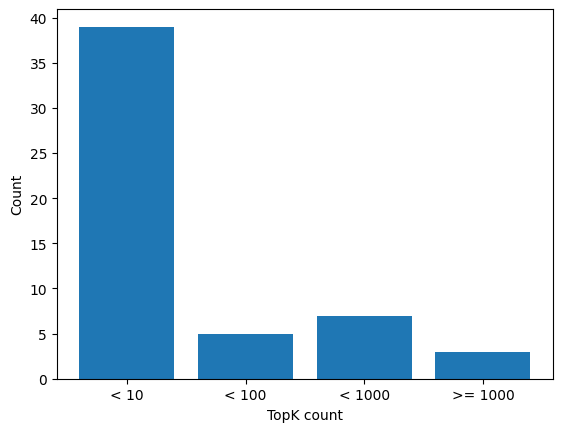

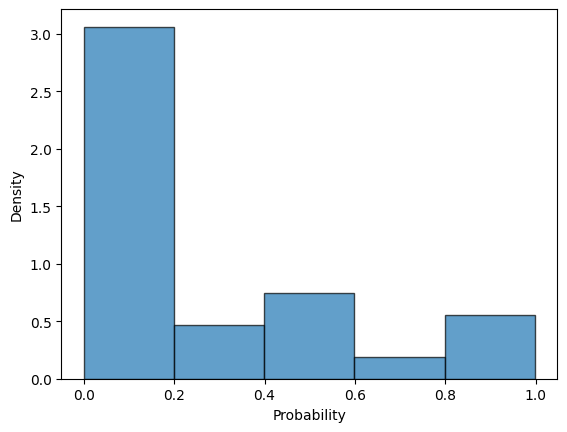

In [11]:
import matplotlib.pyplot as plt

def plot_payload(data):
    # Categorize the data
    count_less_than_10 = sum(1 for pos, prob in data if pos < 10)
    count_less_than_100 = sum(1 for pos, prob in data if 10 <= pos < 100)
    count_less_than_1000 = sum(1 for pos, prob in data if 100 <= pos < 1000)
    count_greater_than_1000 = sum(1 for pos, prob in data if pos >= 1000)


    # Labels for the bars
    categories = ['< 10', '< 100', '< 1000', '>= 1000']

    # Counts for each category
    counts = [count_less_than_10, count_less_than_100, count_less_than_1000, count_greater_than_1000]

    # Create the bar plot
    plt.bar(categories, counts)
    plt.xlabel('TopK count')
    plt.ylabel('Count')
    plt.show()
    
def plot_histogram(data):
    # Extract the probabilities from the input data
    probabilities = [prob for pos, prob in data]

    # Create a histogram with 5 bins for the probabilities
    plt.hist(probabilities, bins=5, edgecolor='k', alpha=0.7, density=True)

    # Labeling the plot
    plt.xlabel('Probability')
    plt.ylabel('Density')
    
    # Show the plot
    plt.show()
    
# exemple
data = payload['real_topk']
plot_payload(data)
plot_histogram(data)

> **T.3**: calculer le diagramme topK pour tous les textes générés collectivement et pour les textes originaux. Comparer qualitativement les résultats obtenus et vérifier si cela est compatible avec l'attendu (notamment, dans les textes originaux il devrait y avoir davantage de tokens dans les top 100, 1000 ou 1000+)

> (Attention: il faudra processer chaque review individuellement, pas concatener toutes les reviews ensemble; et après faire le "flatten" de la liste comme ici:

In [12]:
# Sample input: a sequence of sequences
sequence_of_sequences = [[('a', 'b'), ('c', 'd'), ('e', 'f')], [('a', 'b'), ('d', 'e')]]

# Flatten the sequence of sequences into a single sequence
flattened_sequence = [item for sublist in sequence_of_sequences for item in sublist]

print(flattened_sequence)

[('a', 'b'), ('c', 'd'), ('e', 'f'), ('a', 'b'), ('d', 'e')]


> **T.4**: vous pouvez aussi voir avec les distributions de probabilité de la même façon que pour la tâche antérieure

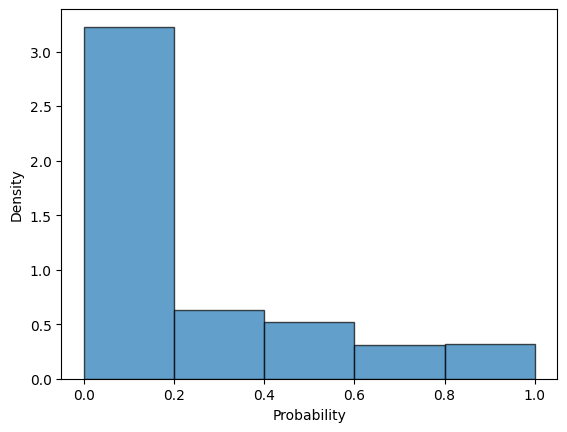

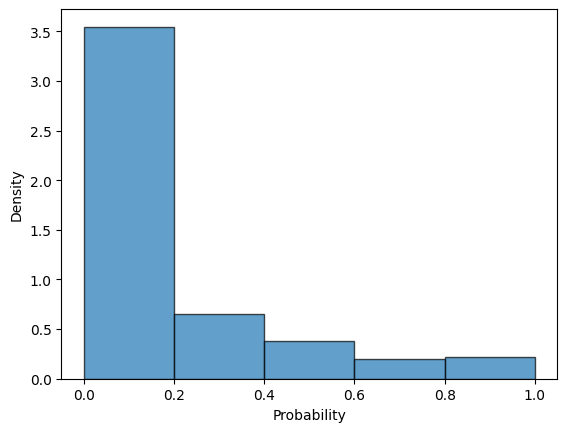

In [14]:
### SOLUTION:
payloads=[]
for t in gen_texts[:10]:
    pl = lm.check_probabilities(t, topk=5)
    payloads.append(pl['real_topk'])

data = [item for sublist in payloads for item in sublist]
plot_histogram(data)

payloads=[]
for t in not_gen_texts[:10]:
    pl = lm.check_probabilities(t, topk=5)
    payloads.append(pl['real_topk'])

data = [item for sublist in payloads for item in sublist]
plot_histogram(data)

### Utiliser la perplexité du LM

On a vu que la perplexité d'une séquence de tokens $X = (x_0, \ldots, x_t)$ est définie en tant que:

$$PPL(X) = \exp\{-\frac{1}{t}\sum_i^t \log p_\theta(x_i | x_{<i})\}$$

où $p_\theta$ est la probabilité estimé par un modèle de language avec paramètres (après entrainement) $\theta$

In [15]:
from transformers import AutoModelForCausalLM, AutoTokenizer
model = AutoModelForCausalLM.from_pretrained("gpt2")
tokenizer = AutoTokenizer.from_pretrained("gpt2")

Le bloc suivant nous montre comment calculer la perplexité d'un LLM par rapport à une phrase donnée en utilisant directement la cross-entropy loss:

In [16]:
text=gen_texts[0]
inputs = tokenizer(text, return_tensors = "pt")
loss = model(input_ids = inputs["input_ids"], labels = inputs["input_ids"]).loss
ppl = torch.exp(loss)
print(ppl.item())

text=not_gen_texts[0]
inputs  = tokenizer(text, return_tensors = "pt")
loss = model(input_ids = inputs["input_ids"], labels = inputs["input_ids"]).loss
ppl = torch.exp(loss)
print(ppl.item())

14.44070053100586
39.76523971557617


> **T.5**: évaluer la perplexité sur un sous_ensemble (par exemple 20 chaque) des données (générés/non-générés)

In [17]:
perps=[]
for text in gen_texts[:20]:
    inputs = tokenizer(text, return_tensors = "pt")
    loss = model(input_ids = inputs["input_ids"], labels = inputs["input_ids"]).loss
    ppl = torch.exp(loss)
    perps.append(ppl.item())
print("average perplexity for generated data: ", np.mean(perps))

perps=[]
for text in not_gen_texts[:20]:
    inputs = tokenizer(text, return_tensors = "pt")
    loss = model(input_ids = inputs["input_ids"], labels = inputs["input_ids"]).loss
    ppl = torch.exp(loss)
    perps.append(ppl.item())
print("average perplexity for not generated data: ", np.mean(perps))

average perplexity for generated data:  23.36303119659424
average perplexity for not generated data:  42.4838828086853
